Approximating CDFs for Nash distribution

In [1]:
using Random
using DataFrames
using CSV
using Statistics
using Printf
using Distributions
using LinearAlgebra
using Plots


struct Fighter
    name::String
    h::Int16
    f::Int16
    l::Int16
    t::Int16
end

const MXS = 100
const MXV = 20
const MNV = 1

function random_fighter(h0::Int = MNV, f0::Int = MNV, l0::Int = MNV, t0::Int = MNV)::Fighter
    flag = true
    while flag
        h = h0 + rand(0:(MXV - h0), 1)[1]
        f = f0 + rand(0:(MXV - f0), 1)[1]
        l = l0 + rand(0:(MXV - l0), 1)[1]
        t = t0 + rand(0:(MXV - t0), 1)[1]
        mm = minimum([h, f])
        budget = h*f+h*l+f*t
        if budget <= MXS && budget + mm > MXS
            flag = false
            return Fighter("No Name", h, f, l, t)
        end
    end
end

function eval_battle(a::Fighter, b::Fighter)::Int
    a_finds = a.f >= b.h
    b_finds = b.f >= a.h
    if a_finds && b_finds
        if a.t > b.t
            return 1
        end
        if a.t < b.t
            return -1
        end
        if a.t == b.t
            if a.l > b.l
                return 1
            end
            if a.l < b.l
                return -1
            end
            if a.l == b.l
                if a.h > b.h
                    return 1
                end
                if a.h < b.h
                    return -1
                end
                if a.h == b.h
                    return 0
                end
            end
        end
    end
    if a_finds && !b_finds
        return 1
    end
    if !a_finds && b_finds
        return -1
    end
    if !a_finds && !b_finds
        if a.l > b.l
            return 1
        end
        if a.l < b.l
            return -1
        end
        if a.l == b.l
            if a.t > b.t
                return 1
            end
            if a.t < b.t
                return -1
            end
            if a.t == b.t
                if a.f > b.f
                    return 1
                end
                if a.f < b.f
                    return -1
                end
                if a.f == b.f
                    return 0
                end
            end
        end
    end
end

function random_tournament_winner(c::Int, f::Function = random_fighter)::Fighter
    if c==0
        return f()
    end
    a = random_tournament_winner(c-1, f)
    b = random_tournament_winner(c-1, f)
    res = eval_battle(a, b)
    if res == 1
        return a
    else
        return b
    end
end


tab = CSV.read("census_yob2022_names.txt", DataFrame, header = false)
names = tab.Column1
adjectives = CSV.read("adjectives.csv", DataFrame)
nouns = CSV.read("nouns.csv", DataFrame)

function random_name_and_stat()::Fighter
    vp = [0, 0, 0, 0]
    nametype = rand(1:5)
    name = ""
    if nametype == 1 || nametype == 2
        nm = rand(names)
        adj_i = rand(1:nrow(adjectives))
        adj = adjectives[adj_i, :adjective]
        vp[1] = vp[1] + adjectives[adj_i, :H]
        vp[2] = vp[2] + adjectives[adj_i, :F]
        vp[3] = vp[3] + adjectives[adj_i, :L]
        vp[4] = vp[4] + adjectives[adj_i, :T]
        if nametype == 1
            name = string(nm, " the ", adj)
        end
        if nametype == 2
            name = string(adj, " ", nm)
        end
    end
    if nametype == 3 || nametype == 4
        nm = rand(names)
        noun_i = rand(1:nrow(nouns))
        noun = nouns[noun_i, :noun]
        vp[1] = vp[1] + nouns[noun_i, :H]
        vp[2] = vp[2] + nouns[noun_i, :F]
        vp[3] = vp[3] + nouns[noun_i, :L]
        vp[4] = vp[4] + nouns[noun_i, :T]    
        if nametype == 3
            name = string(nm, " the ", noun)
        end
        if nametype == 4
            name = string(noun, " ", nm)
        end
    end
    if nametype == 5
        adj_i = rand(1:nrow(adjectives))
        adj = adjectives[adj_i, :adjective]
        vp[1] = vp[1] + adjectives[adj_i, :H]
        vp[2] = vp[2] + adjectives[adj_i, :F]
        vp[3] = vp[3] + adjectives[adj_i, :L]
        vp[4] = vp[4] + adjectives[adj_i, :T]
        noun_i = rand(1:nrow(nouns))
        noun = nouns[noun_i, :noun]
        vp[1] = vp[1] + nouns[noun_i, :H]
        vp[2] = vp[2] + nouns[noun_i, :F]
        vp[3] = vp[3] + nouns[noun_i, :L]
        vp[4] = vp[4] + nouns[noun_i, :T]    
        name = string(adj, " ", noun)
    end
    Fighter(name, vp[1], vp[2], vp[3], vp[4])
end

function rand_rename(a::Fighter, n_tries::Int = 10)::Fighter
    best_score = 0.0
    best_b = random_name_and_stat()
    for ii in 1:n_tries
        b = random_name_and_stat()
        b_norm = sqrt(b.h^2 + b.f^2 + b.l^2 + b.t^2)
        score = (a.h * b.h + a.f * b.f + a.l * b.l + a.t * b.t)/b_norm
        if score > best_score
            best_score = score
            best_b = b
        end
    end
    return Fighter(best_b.name, a.h, a.f, a.l, a.t)
end

function eval_battle_list(a::Fighter, bs::Array{Fighter})::Int
    score = 0
    for ii in 1:length(bs)
        score = score + eval_battle(a, bs[ii])
    end
    return score
end

function eval_battle_list2(a::Fighter, bs::Array{Fighter}, w::Vector{Float64})::AbstractFloat
    score = 0.0
    for ii in 1:length(bs)
        score = score + w[ii] * eval_battle(a, bs[ii])
    end
    return score
end


function pick_best(as::Array{Fighter}, bs::Array{Fighter})::Fighter
    bestscore = -999
    bestf = as[1]
    for ii in 1:length(as)
        score = eval_battle_list(as[ii], bs)
        if score > bestscore
            bestscore = score
            bestf = as[ii]
        end
    end
    return bestf
end

function pick_best_rdmly(as::Array{Fighter}, bs::Array{Fighter}, ntries::Int)::Fighter
    bestscore = -999
    bestf = rand(as)
    for ii in 1:ntries
        f = rand(as)
        score = eval_battle_list(f, bs)
        if score > bestscore
            bestscore = score
            bestf = f
        end
    end
    return bestf
end

function pick_best_rdmly_g(g::Function, bs::Array{Fighter}, ntries::Int)::Fighter
    bestscore = -999
    bestf = g()
    for ii in 1:ntries
        f = g()
        score = eval_battle_list(f, bs)
        if score > bestscore
            bestscore = score
            bestf = f
        end
    end
    return bestf
end

function fighters_to_df(as::Array{Fighter})::DataFrame
    names = Array{String}(undef, length(as))
    hs = Array{Int}(undef, length(as))
    fs = Array{Int}(undef, length(as))
    ls = Array{Int}(undef, length(as))
    ts = Array{Int}(undef, length(as))
    for ii in 1:length(as)
        names[ii] = as[ii].name
        hs[ii] = as[ii].h
        fs[ii] = as[ii].f
        ls[ii] = as[ii].l
        ts[ii] = as[ii].t    
    end
    df = DataFrame(name = names, h = hs, f = fs, l = ls, t = ts)
    return df
end

function fpart(x::AbstractFloat)::AbstractFloat
  return x - trunc(x)
end

function eval_team_battle(as::Array{Fighter}, bs::Array{Fighter})::Int
    a_i = 1
    b_i = 1
    while (a_i <= length(as)) && (b_i <= length(bs))
        res = eval_battle(as[a_i], bs[b_i])
        if res == 1
            b_i = b_i + 1
        else
            a_i = a_i + 1
            if res == 0
                b_i = b_i + 1
            end
        end
    end
    a_out = (a_i > length(as))
    b_out = (b_i > length(as))
    if a_out
        if b_out
            return 0
        else
            return -1
        end
    else
        return 1
    end
end

function compare_generator(f1, f2, limit)
    a_i = 1
    b_i = 1
    f_a = f1()
    f_b = f2()
    while (a_i < limit) && (b_i < limit)
        res = eval_battle(f_a, f_b)
        if res != -1
            b_i = b_i + 1
            f_b = f2()
        end
        if res != 1
            a_i = a_i + 1
            f_a = f1()
        end
    end
    return (a_i/limit, b_i/limit)
end

function random_team(f::Function, team_size::Int)::Array{Fighter}
    team = Array{Fighter}(undef, team_size)
    for i in 1:team_size
        team[i] = f()
    end
    return team
end

random_team (generic function with 1 method)

In [2]:
20 * 20 * 20 * 20

160000

In [3]:
library = Array{Fighter}(undef, 160000)
f_i = 1
for h in MNV:MXV
    for f in MNV:MXV
        for l in MNV:MXV
            for t in MNV:MXV
                if (h * f + h*l + f*t) <= MXS && (h * f + h*l + f*t + min(h, f) > MXS)
                    ff = rand_rename(Fighter(" ", h, f, l, t), 100)
                    library[f_i] = ff
                    f_i = f_i + 1
                end
            end
        end
    end
end
library = library[1:(f_i-1)]

770-element Vector{Fighter}:
 Fighter("Uber Politician", 1, 4, 16, 20)
 Fighter("Pizza Joelee", 1, 4, 20, 19)
 Fighter("Fiery Yosuf", 1, 5, 5, 18)
 Fighter("Maluhia the Victorious", 1, 5, 10, 17)
 Fighter("Giant Heily", 1, 5, 15, 16)
 Fighter("Addilyne the Risky", 1, 5, 20, 15)
 Fighter("Arran the Super", 1, 6, 4, 15)
 Fighter("Frozen Engine", 1, 6, 10, 14)
 Fighter("Giant Sumaiya", 1, 6, 16, 13)
 Fighter("Insane Sword", 1, 7, 2, 13)
 Fighter("Daring Keyana", 1, 7, 9, 12)
 Fighter("Trevonte the Donut", 1, 7, 16, 11)
 Fighter("Warrior Insha", 1, 8, 4, 11)
 ⋮
 Fighter("Silent Will", 18, 3, 2, 3)
 Fighter("Karah the Blanket", 18, 4, 1, 2)
 Fighter("Hylia the Silent", 19, 1, 4, 5)
 Fighter("Furry Kangaroo", 19, 2, 2, 12)
 Fighter("Damani the Silent", 19, 2, 3, 2)
 Fighter("Agile Mushroom", 19, 3, 1, 8)
 Fighter("Underwater Vela", 19, 3, 2, 1)
 Fighter("Elusive Salvatore", 19, 4, 1, 1)
 Fighter("Unreliable Emeline", 20, 1, 3, 20)
 Fighter("Hatim the Unreliable", 20, 2, 1, 20)
 Fighter("Drag

## Nash prob dist

In [4]:
nash_env = library
0

0

In [8]:
w = [1.0/length(nash_env) for n=1:length(nash_env)]
eps = 0.1

0.1

In [ ]:
nits = 1000000
scores = [eval_battle_list2(ff, nash_env, w) for ff in nash_env]
prev_score = maximum(scores)
for i in 1:nits
    scores = [eval_battle_list2(ff, nash_env, w) for ff in nash_env]
    mxv, mxi = findmax(scores)
    w[mxi] = w[mxi] + eps
    w = w./sum(w)
    if mod1(i, 20000)==1
        #print("      ")
        #println((maximum(scores), maximum(w * length(nash_env)), minimum(w * length(nash_env))))
        mxv, mxi = findmax(w)
        #println(nash_env[mxi])
        mxv, mxi = findmax(scores)
        println((nash_env[mxi], w[mxi], scores[mxi]))
        if prev_score < maximum(scores)
            eps = eps/2
            println(eps)
        end
        prev_score = maximum(scores)
    end
end
maximum([eval_battle_list2(ff, nash_env, w) for ff in library])

In [27]:
# reduce size to speed up
inds_sel = findall(w .> 0.00000001/length(nash_env))
nash_env = nash_env[inds_sel]

256-element Vector{Fighter}:
 Fighter("Insane Sword", 1, 7, 2, 13)
 Fighter("Warrior Insha", 1, 8, 4, 11)
 Fighter("Zinc Eero", 1, 9, 1, 10)
 Fighter("Icy Gabe", 1, 11, 1, 8)
 Fighter("Stoney the Xcecutive", 1, 12, 4, 7)
 Fighter("Heroic Xenovia", 1, 13, 9, 6)
 Fighter("Valiant Giant", 2, 5, 10, 14)
 Fighter("Crazy Zookeeper", 2, 5, 12, 13)
 Fighter("Nutritious Politician", 2, 5, 15, 12)
 Fighter("Dhruv the Bee", 2, 6, 8, 12)
 Fighter("Nutritious Trampoline", 2, 6, 11, 11)
 Fighter("Xceeding Candle", 2, 6, 14, 10)
 Fighter("Giant Robot", 2, 7, 1, 12)
 ⋮
 Fighter("Hank the Paper", 13, 2, 5, 4)
 Fighter("Amaly the Egg", 13, 3, 3, 7)
 Fighter("Pigeon Rivers", 13, 3, 4, 3)
 Fighter("Gentle Kamea", 13, 4, 3, 2)
 Fighter("Damiri the Agile", 13, 5, 2, 1)
 Fighter("Mouse Kaylen", 13, 6, 1, 1)
 Fighter("Eadric the Blueberry", 14, 1, 6, 2)
 Fighter("Kangaroo Amiira", 14, 2, 4, 8)
 Fighter("Blanket Marko", 14, 2, 5, 1)
 Fighter("Zebra Keyren", 14, 3, 3, 5)
 Fighter("Jory the Young", 14, 4, 2, 4)


In [29]:
w = w[inds_sel]

256-element Vector{Float64}:
 0.006395651239168267
 0.005220613627212076
 0.004309029519422299
 0.014749872378128871
 0.006830929866698491
 1.1629352944687189e-5
 0.008640186093624007
 0.001009993192327799
 0.005510431621331581
 1.1820500331321804e-8
 0.004876368607646142
 0.005015913361779267
 0.010694876828287745
 ⋮
 0.02404492445830053
 0.002780946544173929
 0.011241368448353517
 0.009757744556244464
 0.004253156601569645
 4.1994900025236676e-5
 0.00212165454953191
 3.8821717950298773e-11
 0.009406577183277394
 0.004579288874936598
 3.0198624006681294e-7
 5.8892634876971216e-6

In [427]:
nits = 1000000
prev_score = maximum(scores)
for i in 1:nits
    scores = [eval_battle_list2(ff, nash_env, w) for ff in nash_env]
    mxv, mxi = findmax(scores)
    w[mxi] = w[mxi] + eps
    w = w./sum(w)
    if mod1(i, 20000)==1
        #print("      ")
        #println((maximum(scores), maximum(w * length(nash_env)), minimum(w * length(nash_env))))
        mxv, mxi = findmax(w)
        #println(nash_env[mxi])
        mxv, mxi = findmax(scores)
        println((nash_env[mxi], w[mxi], scores[mxi]))
        if prev_score < maximum(scores)
            eps = eps/2
            println(eps)
        end
        prev_score = maximum(scores)
    end
end
maximum([eval_battle_list2(ff, nash_env, w) for ff in library])

(Fighter("Zariya the Bagel", 4, 6, 10, 6), 0.0038463775912893775, 0.0020875638362639845)
(Fighter("Elusive Cricket", 11, 5, 3, 2), 0.0078001052494199976, 0.002086970636690025)
(Fighter("Seasoned Heron", 3, 13, 3, 4), 0.009833200102388048, 0.0020863854475035603)
(Fighter("Mirza the Blueberry", 11, 1, 8, 1), 0.012903887956172262, 0.002085802179518882)
(Fighter("Crazy Zookeeper", 2, 5, 12, 13), 0.0051107923517437134, 0.0020852196208897295)
(Fighter("Militant Mantis", 3, 12, 1, 5), 0.007507178787455767, 0.002084628907210515)
(Fighter("Mirza the Blueberry", 11, 1, 8, 1), 0.013051667807954805, 0.0020840027105545776)
(Fighter("Militant Mantis", 3, 12, 1, 5), 0.007705999127097734, 0.002083409775995962)
(Fighter("Militant Mantis", 3, 12, 1, 5), 0.0077426451879185725, 0.002082822288872151)
(Fighter("Giant Robot", 2, 7, 1, 12), 0.015398762047271695, 0.002082257678426362)
(Fighter("Amazing Philosopher", 7, 1, 13, 2), 0.016158971641064647, 0.00208166829576788)
(Fighter("Lucid Malonii", 6, 11, 2, 2)

0.0020591280613163065

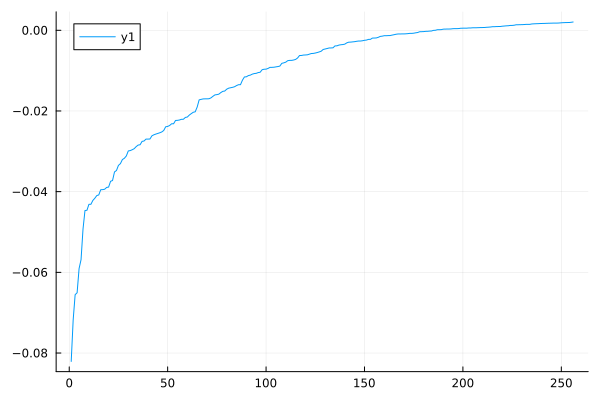

In [431]:
scores = [eval_battle_list2(ff, nash_env, w) for ff in nash_env]
plot(sort(scores))

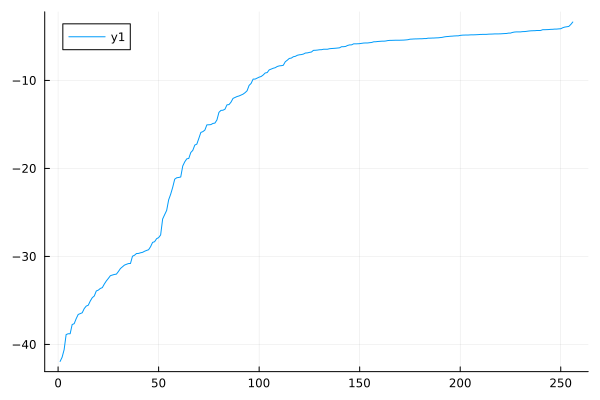

In [429]:
plot(sort([log(wi) for wi in w]))

In [411]:
scores2 = [eval_battle_list2(ff, nash_env, w) for ff in library]
w2 = w .- 0.0000000001
w2[w2 .< 0] .= 0
w2 = w2./sum(w2)
scores2 = [eval_battle_list2(ff, nash_env, w2) for ff in library]
maximum(scores) - maximum(scores2)

-6.043705362557272e-10

In [432]:
ord = sortperm(-w)
savelist = Array{Fighter}(undef, length(nash_env))
for i in 1:length(nash_env)
    f = nash_env[ord[i]]
    savelist[i] = Fighter(string('w', @sprintf("%6.8f", length(nash_env) * w[ord[i]])), f.h, f.f, f.l, f.t)
end

In [433]:
CSV.write("nash_env_base1.csv", fighters_to_df(savelist))

"nash_env_base1.csv"

In [442]:
# check explotability
inds_sel = sortperm(-w)[1:70]
for i in 1:10000
    rt = random_team(() -> nash_env[rand(inds_sel)], 3)
    ff = pick_best(library, rt)
    ev = eval_battle_list(ff, rt)
    if ev < 3
        for fe in rt
            println(fe)
        end
        #println(ff)
        println()
    end
end

Fighter("Terrible Robot", 4, 8, 1, 8)
Fighter("Kooky Wrenlynn", 8, 1, 10, 12)
Fighter("Gentle Kamea", 13, 4, 3, 2)

Fighter("Insane Sword", 1, 7, 2, 13)
Fighter("Knotty Terry", 8, 10, 1, 1)
Fighter("Mirza the Blueberry", 11, 1, 8, 1)

Fighter("Friendly Baboon", 3, 6, 11, 8)
Fighter("Spider Sidra", 8, 9, 1, 2)
Fighter("Paper Livi", 12, 1, 7, 4)

Fighter("Insane Sword", 1, 7, 2, 13)
Fighter("Bubbly Scorpion", 5, 11, 2, 3)
Fighter("Underwater Giant", 8, 2, 8, 10)

Fighter("Kooky Wrenlynn", 8, 1, 10, 12)
Fighter("Carlene the Mosquito", 10, 8, 1, 1)
Fighter("Xtraverted Dog", 2, 9, 9, 7)

Fighter("Amazing Philosopher", 7, 1, 13, 2)
Fighter("Arhareddy the Fish", 11, 6, 2, 2)
Fighter("Icy Gabe", 1, 11, 1, 8)

Fighter("Daily the Icosahedron", 10, 2, 6, 10)
Fighter("Friendly Baboon", 3, 6, 11, 8)
Fighter("Spider Sidra", 8, 9, 1, 2)

Fighter("Dizzy Emmeri", 11, 1, 7, 12)
Fighter("Hungry Avocado", 2, 10, 10, 6)
Fighter("Carlene the Mosquito", 10, 8, 1, 1)

Fighter("Kooky Wrenlynn", 8, 1, 10, 12)
F